# Problem Statement for Link Prediction:

## The work is to identify pairs of nodes that will either form a link or not in the future. 

-dataset_users.csv : A list of all user ids

-dataset_train.csv : A list of relationships among the users. Note that the relationships are directed, i.e., a source user follows a target user. 

-dataset_test.csv : A list of relationships among the users. Similarly, relationships are directed. You will also find an additional column "label'', where 1 indicates a relationship between the source and target users (i.e., positive link) and 0 for otherwise (i.e., negative link). 

# Libraries import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import csv
import random
from pandas.core.frame import DataFrame
import networkx as nx
from random import choice
import pickle
import os

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [2]:
users_df = pd.read_csv('dataset_users.csv')
train_df = pd.read_csv('dataset_train.csv')
test_df = pd.read_csv('dataset_test.csv')

In [3]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281663 entries, 0 to 281662
Data columns (total 2 columns):
Source    281663 non-null int64
Target    281663 non-null int64
dtypes: int64(2)
memory usage: 4.3 MB
None


In [4]:
# check for null values 
train_df.isnull().sum()

Source    0
Target    0
dtype: int64

In [5]:
# checking for duplicate rows and dropping them
train_df = train_df.drop_duplicates()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281663 entries, 0 to 281662
Data columns (total 2 columns):
Source    281663 non-null int64
Target    281663 non-null int64
dtypes: int64(2)
memory usage: 6.4 MB


In [6]:
# cleaned traning data is stored in a different CSV
train_df.to_csv("train_clean.csv", header = False, index = False)

In [7]:
# graph info
g = nx.read_edgelist("train_clean.csv",delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 105010
Number of edges: 281663
Average in degree:   2.6822
Average out degree:   2.6822


In [8]:
# storing small sample of the dataset
pd.read_csv("train_clean.csv", nrows=50).to_csv("train_sample.csv",header=False,index=False)
subgraph = nx.read_edgelist("train_sample.csv", delimiter=',', create_using=nx.DiGraph(), nodetype=int)

Name: 
Type: DiGraph
Number of nodes: 99
Number of edges: 50
Average in degree:   0.5051
Average out degree:   0.5051


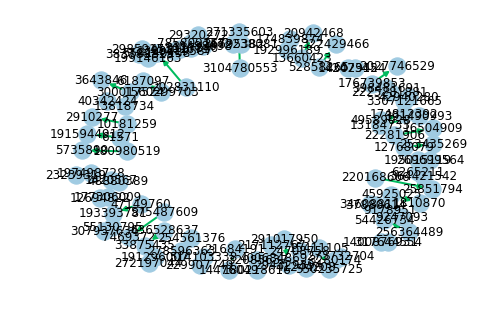

In [9]:
# visualizing the subgraph
pos=nx.spring_layout(subgraph)
nx.draw(subgraph,pos,node_color='#A0CBE2',edge_color='#00bb5e',width=2,edge_cmap=plt.cm.Blues,with_labels=True)
plt.savefig("graph_sample.pdf")
print(nx.info(subgraph))

In [10]:
# No of Unique users 
print("The number of unique users: ",len(g.nodes()))

The number of unique users:  105010


## Indegree Analysis

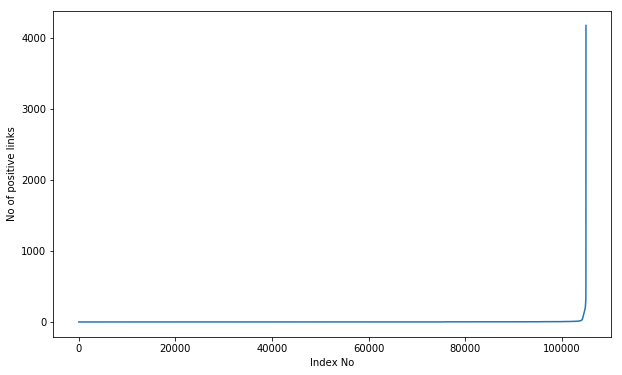

In [11]:
indegree = list(dict(g.in_degree()).values())
indegree.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree)
plt.xlabel('Index No')
plt.ylabel('No of positive links')
plt.show()

### Observation
        Most of the users have very few followers.
        Only a few have higher number of followers.

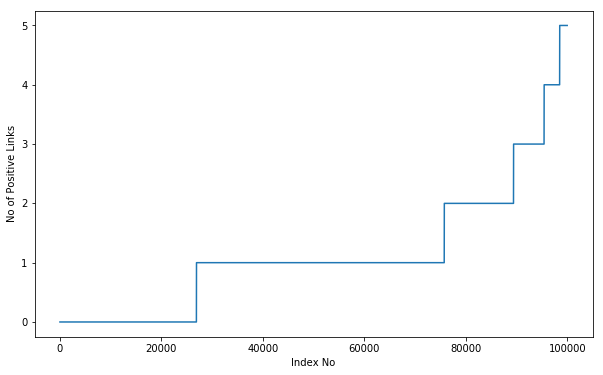

In [12]:
plt.figure(figsize=(10,6))
plt.plot(indegree[0:100000])
plt.xlabel('Index No')
plt.ylabel('No of Positive Links')
plt.show()

### Observation
    Nearly 25K users have 0 followers
    Nearly 53K users have 1 followers
    Almost 100K users have less than 5 followers

In [13]:
# 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(indegree,90+i))

90 percentile value is 3.0
91 percentile value is 4.0
92 percentile value is 4.0
93 percentile value is 4.0
94 percentile value is 5.0
95 percentile value is 5.0
96 percentile value is 6.0
97 percentile value is 7.0
98 percentile value is 10.0
99 percentile value is 20.0
100 percentile value is 4180.0


In [14]:
# 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(indegree,99+(i/100))) 

99.1 percentile value is 23.918999999994412
99.2 percentile value is 29.927999999999884
99.3 percentile value is 41.0
99.4 percentile value is 66.0
99.5 percentile value is 95.0
99.6 percentile value is 124.96399999999267
99.7 percentile value is 149.0
99.8 percentile value is 178.0
99.9 percentile value is 228.99100000000908
100.0 percentile value is 4180.0


### Observation
    99% of users have less than 20 followers.
    99.9% users have less than 229 followers.
    Only 0.1% users have more than 229 followers.

/Applications/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


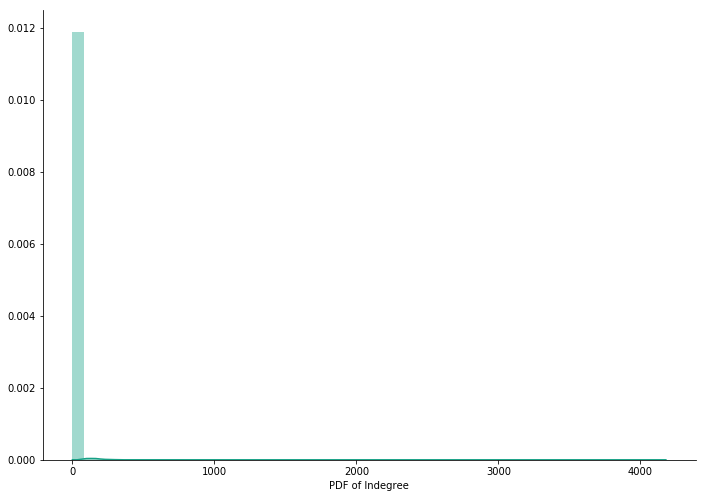

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(indegree, color='#16A085')
plt.xlabel('PDF of Indegree')
sns.despine()

In [16]:
print('No of users having Zero Followers : ' ,sum(np.array(indegree)==0))
print(' % of users having Zero Followers : ',sum(np.array(indegree)==0)*100/len(indegree))

No of users having Zero Followers :  26901
 % of users having Zero Followers :  25.617560232358823


## Outdegree Analysis

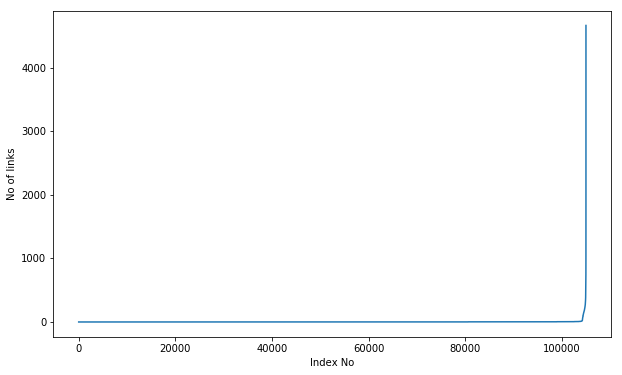

In [17]:
outdegree = list(dict(g.out_degree()).values())
outdegree.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree)
plt.xlabel('Index No')
plt.ylabel('No of links')
plt.show()

### Observation
    Most of users follows a few people
    Only a few are following higher number of people.

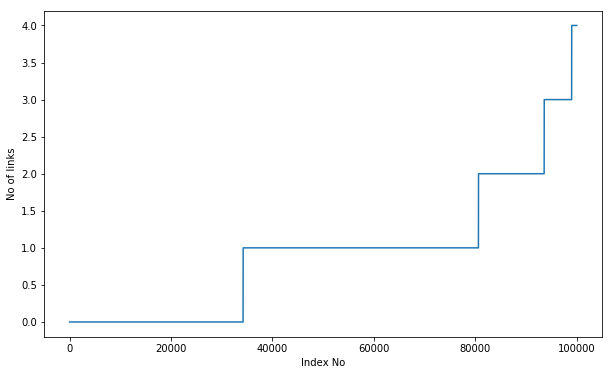

In [18]:
plt.figure(figsize=(10,6))
plt.plot(outdegree[0:100000])
plt.xlabel('Index No')
plt.ylabel('No of links')
plt.show()

### Observations
    Nearly 35K users are not following any user.
    Almost 40K users are following 1 User.
    Almost 100K users are following less than 4 users.

In [19]:
# 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(outdegree,90+i))

90 percentile value is 3.0
91 percentile value is 3.0
92 percentile value is 3.0
93 percentile value is 3.0
94 percentile value is 3.0
95 percentile value is 4.0
96 percentile value is 4.0
97 percentile value is 5.0
98 percentile value is 6.0
99 percentile value is 11.0
100 percentile value is 4666.0


In [20]:
# 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(outdegree,99+(i/100)))

99.1 percentile value is 12.0
99.2 percentile value is 16.0
99.3 percentile value is 26.937000000005355
99.4 percentile value is 87.94600000001083
99.5 percentile value is 126.0
99.6 percentile value is 160.0
99.7 percentile value is 190.0
99.8 percentile value is 235.9820000000036
99.9 percentile value is 319.9910000000091
100.0 percentile value is 4666.0


### Observations
    99% of users follow less than 11 users.
    99.9% of users follow less than 320 users.
    Only 0.1% users follow more than 320 users.

Text(0.5, 0, 'PDF of Outdegree')

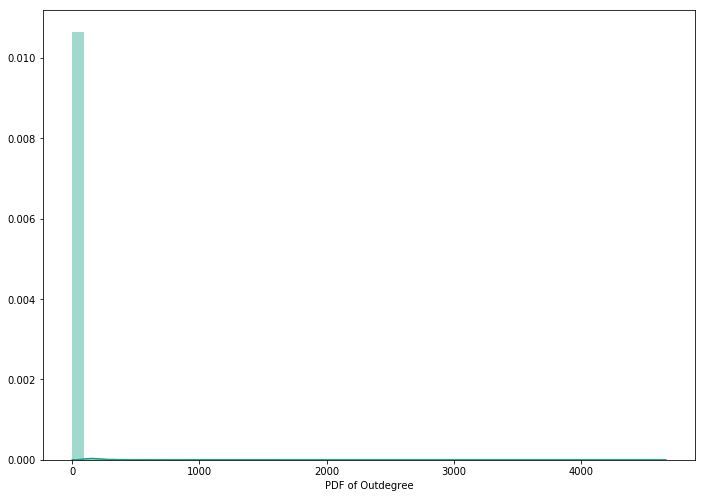

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(outdegree, color='#16A085')
plt.xlabel('PDF of Outdegree')

In [22]:
print('No of users who are following zero people : ' ,sum(np.array(outdegree)==0))
print(' % of users who are following zero people : ',sum(np.array(outdegree)==0)*100/len(outdegree) )

No of users who are following zero people :  34204
 % of users who are following zero people :  32.57213598704885


In [23]:
dict_in = dict(g.in_degree())
dict_out = dict(g.out_degree())
d = Counter(dict_in) + Counter(dict_out)
in_out_degree = list(d.values())

### Users with 0 follower and 0 following

In [24]:
zero_count=0

for i in g.nodes():
    if len(list(g.predecessors(i)))==0 :
        if len(list(g.successors(i)))==0:
            zero_count+=1
print('No of users who are not following anyone and also have 0 followers : ',zero_count)

No of users who are not following anyone and also have 0 followers :  0


## Combine both indegree and out degree

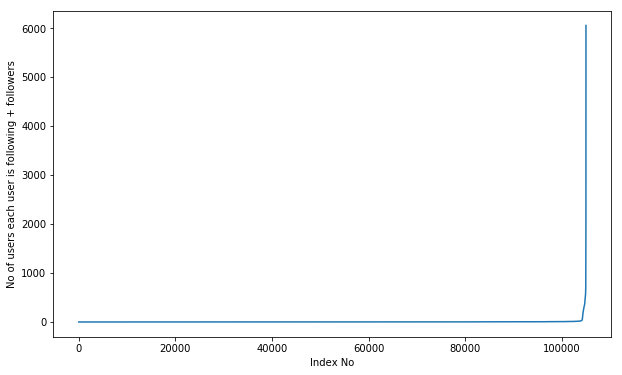

In [25]:
in_out_degree.sort()
plt.figure(figsize=(10,6))
plt.plot(in_out_degree)
plt.xlabel('Index No')
plt.ylabel('No of users each user is following + followers')
plt.show()

### Observation:
    Most of the users are following and followed by fewer users.
    Only a few are following and followed by higher number of users.

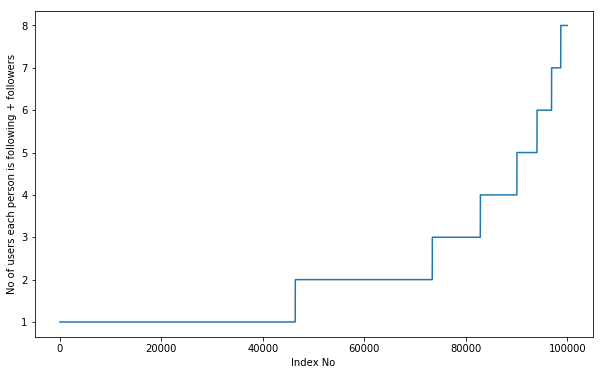

In [26]:
plt.figure(figsize=(10,6))
plt.plot(in_out_degree[0:100000])
plt.xlabel('Index No')
plt.ylabel('No of users each person is following + followers')
plt.show()

### Observations:
    Nearly 45K users have one overall degree.
    Almost 85K users have less than 4 overall degree.
    Almost 100K users have less than 8 overall degree.

In [27]:
# 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(in_out_degree,90+i))

90 percentile value is 6.0
91 percentile value is 6.0
92 percentile value is 6.0
93 percentile value is 7.0
94 percentile value is 7.0
95 percentile value is 8.0
96 percentile value is 9.0
97 percentile value is 11.0
98 percentile value is 14.0
99 percentile value is 24.0
100 percentile value is 6061.0


In [28]:
# 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(in_out_degree,99+(i/100)))

99.1 percentile value is 29.0
99.2 percentile value is 36.0
99.3 percentile value is 66.0
99.4 percentile value is 179.94600000001083
99.5 percentile value is 240.0
99.6 percentile value is 294.92799999998533
99.7 percentile value is 342.0
99.8 percentile value is 412.0
99.9 percentile value is 533.0
100.0 percentile value is 6061.0


### Observations:
    99% of users have less than 24 overall degree.
    99.9% of users have less than 533 overall degree.
    Only 0.1% have more than 533 overall degree.

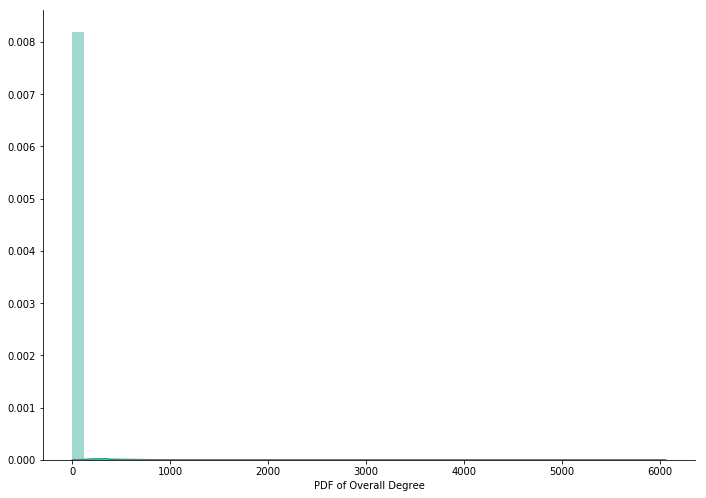

In [29]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(in_out_degree, color='#16A085')
plt.xlabel('PDF of Overall Degree')
sns.despine()

In [30]:
print('Min of no of followers + following is',min(in_out_degree))
print(sum(np.array(in_out_degree) == min(in_out_degree)),' users having minimum no of followers + following')

Min of no of followers + following is 1
46380  users having minimum no of followers + following


In [31]:
print('Max of no of followers + following is',max(in_out_degree))
print(sum(np.array(in_out_degree) == max(in_out_degree)),' users having maximum no of followers + following')

Max of no of followers + following is 6061
1  users having maximum no of followers + following


In [32]:
print('No of users having followers + following less than 10 are',sum(np.array(in_out_degree)<10))

No of users having followers + following less than 10 are 100957


## creating a sample of train andd test data

In [33]:
r = csv.reader(open('train_clean.csv','r'))
edges = dict()
for edge in r:
    edges[(edge[0], edge[1])] = 1

In [34]:
negative_edges = set([])

In [35]:
while (len(negative_edges)<281663):
        i = choice(train_df.Source.values)
        j = choice(train_df.Target.values)
        tmp = edges.get((i,j),-1)
        if tmp == -1 and i!=j:
            try:
                if (nx.shortest_path_length(g,source=i,target=j) > 2): 
                    negative_edges.add((i,j))
                else:
                    continue     
            except:
                    negative_edges.add((i,j))
        else:
            continue

In [36]:
negative_edges = list(negative_edges)

In [37]:
df_neg = pd.DataFrame(negative_edges)
df_neg = df_neg.drop_duplicates()

In [38]:
print("Number of positive edges: ", train_df.shape[0])
print("Number of negative edges: ", df_neg.shape[0])

Number of positive edges:  281663
Number of negative edges:  281663


In [39]:
X_test_pos = test_df.loc[test_df['label'] == 1][['Source','Target']]

In [40]:
y_train_pos = np.ones([281663,1])
y_train_pos = pd.DataFrame(y_train_pos)
y_test_pos = test_df.loc[test_df['label'] == 1][['label']]
X_train_neg = df_neg
X_train_neg
X_test_neg = test_df.loc[test_df['label'] == 0][['Source','Target']]

y_train_neg = np.zeros([281663,1])
y_train_neg = pd.DataFrame(y_train_neg)

y_test_neg = test_df.loc[test_df['label'] == 0][['label']]

X_train_pos = train_df 

In [41]:
X_train_pos.to_csv('itrain_pos.csv',header=False, index=False)
X_test_pos.to_csv('itest_pos.csv',header=False, index=False)
X_train_neg.to_csv('itrain_neg.csv',header=False, index=False)
X_test_neg.to_csv('itest_neg.csv',header=False, index=False)

In [42]:
X_train = np.concatenate((X_train_pos, X_train_neg), axis=0)
X_test = np.concatenate((X_test_pos, X_test_neg), axis=0)

In [43]:
y_train = np.concatenate((y_train_pos, y_train_neg))
y_test = np.concatenate((y_test_pos, y_test_neg))

In [44]:
print("Shape of traning data: ", X_train.shape)
print("Shape of test data: ", X_test.shape)
print("Shape of y_train data: ", y_train.shape)
print("Shape of y_test data: ", y_test.shape)

Shape of traning data:  (563326, 2)
Shape of test data:  (187770, 2)
Shape of y_train data:  (563326, 1)
Shape of y_test data:  (187770, 1)


In [45]:
df_train = pd.DataFrame(X_train)
df_test = pd.DataFrame(X_test)

In [46]:
df_train.to_csv('itrain_new.csv',header=False, index=False)
df_test.to_csv('itest_new.csv',header=False, index=False)

In [47]:
df_train_y = pd.DataFrame(y_train)
df_test_y = pd.DataFrame(y_test)

In [48]:
df_train_y.to_csv('itrain_y.csv',header=False, index=False)
df_test_y.to_csv('itest_y.csv',header=False, index=False)

In [49]:
n_train =  563324
s = 100000
skip_train = sorted(random.sample(range(1,n_train+1),n_train-s))

In [50]:
df_train = pd.read_csv('itrain_new.csv', skiprows=skip_train,names=['Source', 'Target'])
df_train['label'] = pd.read_csv('itrain_y.csv', skiprows=skip_train,names=['label'])

In [51]:
df_train.head()

,Source,Target,label
0,288996581,5805394,1.0
1,785809157,3117840,1.0
2,10488698,29320272,1.0
3,291017950,294329394,1.0
4,34608811,9247093,1.0


In [52]:
df_train.shape
df_train

,Source,Target,label
0,288996581,5805394,1.0
1,785809157,3117840,1.0
2,10488698,29320272,1.0
3,291017950,294329394,1.0
4,34608811,9247093,1.0
5,199146163,29859151,1.0
6,1400876931,317644554,1.0
7,13818734,40342424,1.0
8,273732704,3280174,1.0
9,254561376,278596363,1.0


In [53]:
n_test = 187768
s = 50000
skip_test = sorted(random.sample(range(1,n_test+1),n_test-s))

In [54]:
df_test = pd.read_csv('itest_new.csv', skiprows=skip_test,names=['Source', 'Target'])
df_test['label'] = pd.read_csv('itest_y.csv', skiprows=skip_test,names=['label'])

In [55]:
df_test.head()

,Source,Target,label
0,293097098,26926343,1
1,4124426937,26926343,1
2,21019053,26926343,1
3,1452743947,26926343,1
4,2927493038,26926343,1


In [56]:
df_test.shape

(50002, 3)

In [57]:
df_test["label"] = df_test["label"].astype("float")

In [58]:
df_test.dtypes
df_test

,Source,Target,label
0,293097098,26926343,1.0
1,4124426937,26926343,1.0
2,21019053,26926343,1.0
3,1452743947,26926343,1.0
4,2927493038,26926343,1.0
5,298000292,26926343,1.0
6,503715665,26926343,1.0
7,2224003281,26926343,1.0
8,537548369,26926343,1.0
9,1281805,26926343,1.0


#### Jaccard Distance

\begin{equation}
J = \frac{|X\cap Y|}{|X \cup Y|} 
\end{equation}

 - Larger The Jaccard Index, Higher The Probability of Existence of an Edge.

In [59]:
def jaccard_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
    except:
        return 0
    return sim

In [60]:
def jaccard_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                 (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

#### Cosine Distance:

<h5>Otsuka-Ochiai Coefficient</h5>

\begin{equation}
CosineDistance = \frac{|X\cap Y|}{sqrt(|X|\cdot|Y|)} 
\end{equation}

In [61]:
def cosine_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
        return sim
    except:
        return 0

In [62]:
def cosine_for_followers(a,b):
    try:
        
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                     (math.sqrt(len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

#### Page Rank

In [63]:
train_graph=nx.read_edgelist('train_clean.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)

pr = nx.pagerank(train_graph, alpha=0.85)

In [64]:
print('min: ',min(pr.values()))
print('max: ',max(pr.values()))
print('mean: ',float(sum(pr.values())) / len(pr))

min:  2.9761164591119175e-06
max:  0.013170033602037508
mean:  9.522902580716733e-06


In [65]:
mean_pr = float(sum(pr.values())) / len(pr)
print(mean_pr)

9.522902580716733e-06


#### Shortest Path

- Finding The Shortest Path Between Two Nodes, if There are More Than One Connection.

In [66]:
def compute_shortest_path_length(a,b):
    p=-1
    try:
        if train_graph.has_edge(a,b):
            train_graph.remove_edge(a,b)
            p= nx.shortest_path_length(train_graph,source=a,target=b)
            train_graph.add_edge(a,b)
        else:
            p= nx.shortest_path_length(train_graph,source=a,target=b)
        return p
    except:
        return -1

#### Weakly Connected Components

- Helps in Identifying Communties.

In [67]:
wcc=list(nx.weakly_connected_components(train_graph))

def belongs_to_same_wcc(a,b):
    index = []
    if train_graph.has_edge(b,a):
        return 1
    if train_graph.has_edge(a,b):
            for i in wcc:
                if a in i:
                    index= i
                    break
            if (b in index):
                train_graph.remove_edge(a,b)
                if compute_shortest_path_length(a,b)==-1:
                    train_graph.add_edge(a,b)
                    return 0
                else:
                    train_graph.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    index= i
                    break
            if(b in index):
                return 1
            else:
                return 0

#### Adamic / Adar Index 

Adamic/Adar measures is defined as inverted sum of degrees of common neighbours for given two vertices.
$$A(x,y)=\sum_{u \in N(x) \cap N(y)}\frac{1}{log(|N(u)|)}$$

In [68]:
def adar_index(a,b):
    sum=0
    try:
        n=list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
        if len(n)!=0:
            for i in n:
                sum=sum+(1/np.log10(len(list(train_graph.predecessors(i)))))
            return sum
        else:
            return 0
    except:
        return 0

#### Katz's Centrality

Katz centrality computes the centrality for a node 
    based on the centrality of its neighbors. It is a 
    generalization of the eigenvector centrality. The
    Katz centrality for node `i` is
 
$$x_i = \alpha \sum_{j} A_{ij} x_j + \beta,$$
where `A` is the adjacency matrix of the graph G 
with eigenvalues $$\lambda$$.

The parameter $$\beta$$ controls the initial centrality and 

$$\alpha < \frac{1}{\lambda_{max}}.$$

In [69]:
katz = nx.katz.katz_centrality(train_graph,alpha=0.005,beta=1)

In [70]:
print('min: ', min(katz.values()))
print('max: ', max(katz.values()))
print('mean: ', float(sum(katz.values())) / len(katz))

min:  0.0029898453080688695
max:  0.06691879715487685
mean:  0.0030581567534161136


In [71]:
mean_katz = float(sum(katz.values())) / len(katz)
print(mean_katz)

0.0030581567534161136


## Add the above features into train data 

In [72]:
df_train['jaccard_followers'] = df_train.apply(lambda row:
                                            jaccard_for_followers(row['Source'],row['Target']),axis=1)
df_test['jaccard_followers'] = df_test.apply(lambda row:
                                            jaccard_for_followers(row['Source'],row['Target']),axis=1)

In [73]:
df_train['jaccard_followees'] = df_train.apply(lambda row:
                                            jaccard_for_followees(row['Source'],row['Target']),axis=1)
df_test['jaccard_followees'] = df_test.apply(lambda row:
                                            jaccard_for_followees(row['Source'],row['Target']),axis=1)

In [74]:
df_train['cosine_followers'] = df_train.apply(lambda row:
                                            cosine_for_followers(row['Source'],row['Target']),axis=1)
df_test['cosine_followers'] = df_test.apply(lambda row:
                                            cosine_for_followers(row['Source'],row['Target']),axis=1)

In [75]:
df_train['cosine_followees'] = df_train.apply(lambda row:
                                            cosine_for_followees(row['Source'],row['Target']),axis=1)
df_test['cosine_followees'] = df_test.apply(lambda row:
                                            cosine_for_followees(row['Source'],row['Target']),axis=1)

In [76]:
df_train['shortest_path_length'] = df_train.apply(lambda row:
                                            compute_shortest_path_length(row['Source'],row['Target']),axis=1)
df_test['shortest_path_length'] = df_test.apply(lambda row:
                                            compute_shortest_path_length(row['Source'],row['Target']),axis=1)

In [77]:
df_train['belongs_to_same_wcc'] = df_train.apply(lambda row:
                                            belongs_to_same_wcc(row['Source'],row['Target']),axis=1)
df_test['belongs_to_same_wcc'] = df_test.apply(lambda row:
                                            belongs_to_same_wcc(row['Source'],row['Target']),axis=1)

In [78]:
df_train['adar_index'] = df_train.apply(lambda row:
                                            adar_index(row['Source'],row['Target']),axis=1)
df_test['adar_index'] = df_test.apply(lambda row:
                                            adar_index(row['Source'],row['Target']),axis=1)

In [79]:
df_train['page_rank_s'] = df_train.Source.apply(lambda x:pr.get(x,mean_pr))
df_train['page_rank_d'] = df_train.Target.apply(lambda x:pr.get(x,mean_pr))

df_test['page_rank_s'] = df_test.Source.apply(lambda x:pr.get(x,mean_pr))
df_test['page_rank_d'] = df_test.Target.apply(lambda x:pr.get(x,mean_pr))

In [80]:
df_train['katz_s'] = df_train.Source.apply(lambda x: katz.get(x,mean_katz))
df_train['katz_d'] = df_train.Target.apply(lambda x: katz.get(x,mean_katz))

df_test['katz_s'] = df_test.Source.apply(lambda x: katz.get(x,mean_katz))
df_test['katz_d'] = df_test.Target.apply(lambda x: katz.get(x,mean_katz))

In [81]:
df_train

,Source,Target,label,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,shortest_path_length,belongs_to_same_wcc,adar_index,page_rank_s,page_rank_d,katz_s,katz_d
0,288996581,5805394,1.0,0.000000,0.000000,0,0,3,1,0.000000,0.000442,0.000012,0.005708,0.003177
1,785809157,3117840,1.0,0.000000,0.000000,0,0,3,1,0.000000,0.000224,0.000057,0.004200,0.004080
2,10488698,29320272,1.0,0.000000,0.000000,0,0,3,1,0.000000,0.000014,0.000011,0.003063,0.003292
3,291017950,294329394,1.0,0.009804,0.011173,0,0,2,1,0.843899,0.000209,0.000009,0.004573,0.003081
4,34608811,9247093,1.0,0.020000,0.000000,0,0,2,1,0.000000,0.000152,0.000009,0.003745,0.003152
5,199146163,29859151,1.0,0.000000,0.000000,0,0,-1,1,0.000000,0.000003,0.013170,0.002990,0.066876
6,1400876931,317644554,1.0,0.000000,0.000000,0,0,3,1,0.000000,0.000003,0.001109,0.002990,0.005922
7,13818734,40342424,1.0,0.000000,0.000000,0,0,3,1,0.000000,0.000322,0.000022,0.004849,0.003436
8,273732704,3280174,1.0,0.000000,0.000000,0,0,-1,1,0.000000,0.000005,0.000469,0.003017,0.005483
9,254561376,278596363,1.0,0.000000,0.000000,0,0,2,1,0.000000,0.000138,0.000022,0.003876,0.003511


In [82]:
y_train = df_train.label
y_test = df_test.label

In [83]:
df_train.drop(['Source', 'Target','label'],axis=1,inplace=True)
df_test.drop(['Source', 'Target','label'],axis=1,inplace=True)
df_test

,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,shortest_path_length,belongs_to_same_wcc,adar_index,page_rank_s,page_rank_d,katz_s,katz_d
0,0.000802,0.000000,0,0,3,1,0.000000,0.000015,0.004134,0.003212,0.022280
1,0.000000,0.000000,0,0,3,1,0.000000,0.000003,0.004134,0.002990,0.022280
2,0.000000,0.014493,0,0,3,1,0.574593,0.000003,0.004134,0.002990,0.022280
3,0.000000,0.000000,0,0,3,1,0.000000,0.000003,0.004134,0.002990,0.022280
4,0.000000,0.000000,0,0,3,1,0.000000,0.000003,0.004134,0.002990,0.022280
5,0.000805,0.000000,0,0,2,1,0.000000,0.000006,0.004134,0.003032,0.022280
6,0.000000,0.000000,0,0,3,1,0.000000,0.000003,0.004134,0.003017,0.022280
7,0.000000,0.000000,0,0,2,1,0.000000,0.000003,0.004134,0.003005,0.022280
8,0.000000,0.000000,0,0,3,1,0.000000,0.000003,0.004134,0.002990,0.022280
9,0.000000,0.000000,0,0,3,1,0.000000,0.000007,0.004134,0.003022,0.022280


In [84]:
x_train = df_train.values
x_test = df_test.values

y_train = y_train.values
y_test = y_test.values

y_train.reshape(-1,1)
y_test.reshape(-1,1)

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]])

In [85]:
y_test.dtype

dtype('float64')

## classification models on graph based features

In [86]:
from sklearn.metrics import classification_report, precision_score,recall_score,f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn import naive_bayes

## Decision Tree

In [87]:
clf = tree.DecisionTreeClassifier(min_samples_split=40)
clf.fit(x_train, y_train)
pred = clf.predict(x_test)
pre_train_sc = precision_score(y_train,clf.predict(x_train))
pre_test_sc = precision_score(y_test,clf.predict(x_test))
re_train_sc = recall_score(y_train,clf.predict(x_train))
re_test_sc = recall_score(y_test,clf.predict(x_test))
f1_train_sc = f1_score(y_train,clf.predict(x_train))
f1_test_sc = f1_score(y_test,clf.predict(x_test))

print("Train score for precision: ",pre_train_sc,'\n',"Test score for precision: ", pre_test_sc,'\n')
print("Train score for recall: ",re_train_sc,'\n',"Test score for recall: ", re_test_sc,'\n')
print("Train score for F1_score: ",f1_train_sc,'\n',"Test score for F1_score: ", f1_test_sc,'\n')

Train score for precision:  0.8747846406717231 
 Test score for precision:  0.286568970153267 

Train score for recall:  0.8817517665375864 
 Test score for recall:  0.5168525703200776 

Train score for F1_score:  0.8782543864009146 
 Test score for F1_score:  0.3687078360145304 



### Observation:
The model doesn't perform well on the test set, which might caused by overfitting



## K-Nearest-Neighbours

In [88]:
from sklearn.neighbors import KNeighborsClassifier
 
clf = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
clf.fit(x_train, y_train)
 
pre_train_sc = precision_score(y_train,clf.predict(x_train))
pre_test_sc = precision_score(y_test,clf.predict(x_test))
re_train_sc = recall_score(y_train,clf.predict(x_train))
re_test_sc = recall_score(y_test,clf.predict(x_test))
f1_train_sc = f1_score(y_train,clf.predict(x_train))
f1_test_sc = f1_score(y_test,clf.predict(x_test))

print("Train score for precision: ",pre_train_sc,'\n',"Test score for precision: ", pre_test_sc,'\n')
print("Train score for recall: ",re_train_sc,'\n',"Test score for recall: ", re_test_sc,'\n')
print("Train score for F1_score: ",f1_train_sc,'\n',"Test score for F1_score: ", f1_test_sc,'\n')

Train score for precision:  0.8363853277027666 
 Test score for precision:  0.6568170036288232 

Train score for recall:  0.8816120404008144 
 Test score for recall:  0.6144519883608147 

Train score for F1_score:  0.8584033817598756 
 Test score for F1_score:  0.6349285893259834 



### Observation:
The model doesn't perform well on the test set, which might caused by overfitting.

The time and space complexity is large.

## Random Forest

In [89]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

estimators = [10, 50, 100, 250, 500, 1000, 2000]
pre_train_scores = []
pre_test_scores = []
re_train_scores = []
re_test_scores = []
f1_train_scores = []
f1_test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(x_train,y_train)
    pre_train_sc = precision_score(y_train,clf.predict(x_train))
    pre_test_sc = precision_score(y_test,clf.predict(x_test))
    re_train_sc = recall_score(y_train,clf.predict(x_train))
    re_test_sc = recall_score(y_test,clf.predict(x_test))
    f1_train_sc = f1_score(y_train,clf.predict(x_train))
    f1_test_sc = f1_score(y_test,clf.predict(x_test))
    pre_test_scores.append(pre_test_sc)
    pre_train_scores.append(pre_train_sc)
    re_test_scores.append(re_test_sc)
    re_train_scores.append(re_train_sc)
    f1_test_scores.append(f1_test_sc)
    f1_train_scores.append(f1_train_sc)
    print('Estimators = ',i,'Train Score For Precision',pre_train_sc,'test Score For Precision ',pre_test_sc
         ,'\n','Train Score For Recall',re_train_sc,'test Score For Recall ',re_test_sc
         ,'\n','Train Score For F1_scores',f1_train_sc,'test Score For F1_scores ',f1_test_sc,'\n')

Estimators =  10 Train Score For Precision 0.746117095358144 test Score For Precision  0.9067883774749292 
 Train Score For Recall 0.8447842229230708 test Score For Recall  0.8551163918525703 
 Train Score For F1_scores 0.7923910092584792 test Score For F1_scores  0.8801946836390865 

Estimators =  50 Train Score For Precision 0.7515639910932033 test Score For Precision  0.8892773892773893 
 Train Score For Recall 0.8488961635195018 test Score For Recall  0.8325654704170709 
 Train Score For F1_scores 0.7972704435529228 test Score For F1_scores  0.8599874765184722 

Estimators =  100 Train Score For Precision 0.7510766732561424 test Score For Precision  0.8702764392594471 
 Train Score For Recall 0.8493951854365444 test Score For Recall  0.8320805043646945 
 Train Score For F1_scores 0.7972160293759485 test Score For F1_scores  0.8507499690095451 

Estimators =  250 Train Score For Precision 0.7515758906438132 test Score For Precision  0.867291376472078 
 Train Score For Recall 0.84725

In [90]:

max_depth = [5, 7, 9, 11, 12, 13, 15]
train_scores = []
test_scores = []
for i in max_depth:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth = i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators = 500, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(x_train,y_train)
    pre_train_sc = precision_score(y_train,clf.predict(x_train))
    pre_test_sc = precision_score(y_test,clf.predict(x_test))
    re_train_sc = recall_score(y_train,clf.predict(x_train))
    re_test_sc = recall_score(y_test,clf.predict(x_test))
    f1_train_sc = f1_score(y_train,clf.predict(x_train))
    f1_test_sc = f1_score(y_test,clf.predict(x_test))
    pre_test_scores.append(pre_test_sc)
    pre_train_scores.append(pre_train_sc)
    re_test_scores.append(re_test_sc)
    re_train_scores.append(re_train_sc)
    f1_test_scores.append(f1_test_sc)
    f1_train_scores.append(f1_train_sc)
    print('Estimators = ',i,'Train Score For Precision',pre_train_sc,'test Score For Precision ',pre_test_sc
         ,'\n','Train Score For Recall',re_train_sc,'test Score For Recall ',re_test_sc
         ,'\n','Train Score For F1_scores',f1_train_sc,'test Score For F1_scores ',f1_test_sc,'\n')

Estimators =  5 Train Score For Precision 0.75172193990474 test Score For Precision  0.8699796644636503 
 Train Score For Recall 0.8474390195217374 test Score For Recall  0.829898157129001 
 Train Score For F1_scores 0.7967159277504106 test Score For F1_scores  0.8494663688260115 

Estimators =  7 Train Score For Precision 0.7622021452739184 test Score For Precision  0.8853395662900923 
 Train Score For Recall 0.8453630883468402 test Score For Recall  0.8266246362754607 
 Train Score For F1_scores 0.8016316178001553 test Score For F1_scores  0.8549752335569629 

Estimators =  9 Train Score For Precision 0.7661057561400643 test Score For Precision  0.8950633579725449 
 Train Score For Recall 0.8424288394746298 test Score For Recall  0.8221387002909797 
 Train Score For F1_scores 0.8024565773337008 test Score For F1_scores  0.8570525783619819 

Estimators =  11 Train Score For Precision 0.7690161393270721 test Score For Precision  0.8989602772593975 
 Train Score For Recall 0.84173020879

### Observation:
The precision, recall, and F1 scores seems like the best performed ones during the above models. 

According to the randomness of choosing data and features, RF model performs better for avoiding over-fitting.